Cell 1: Import Libraries

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import cv2

Cell 2: Load and Preprocess CIFAR-10

In [23]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (-1, 32, 32, 3))
x_test = np.reshape(x_test, (-1, 32, 32, 3))

print(f"Train set: {x_train.shape}, Test set: {x_test.shape}")

Train set: (50000, 32, 32, 3), Test set: (10000, 32, 32, 3)


Cell 3: Data Visualization

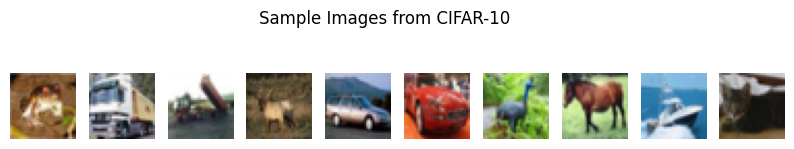

In [24]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.suptitle("Sample Images from CIFAR-10")
plt.show()


Cell 4: Define VAE Encoder and Decoder

In [25]:
latent_dim = 64

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8*8*64, activation='relu')(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name="decoder")

Cell 5: Define VAE with Custom Loss Function

In [26]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_type='bce', **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def test_step(self, data):
      if isinstance(data, tuple):
          data = data[0]

      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)

      if self.loss_type == 'bce':
          recon_loss = tf.reduce_mean(
              tf.keras.losses.binary_crossentropy(data, reconstruction)
          ) * 32 * 32 * 3
      else:
          recon_loss = tf.reduce_mean(tf.square(data - reconstruction)) * 32 * 32 * 3

      kl_loss = -0.5 * tf.reduce_mean(
          1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      )
      total_loss = recon_loss + kl_loss

      self.total_loss_tracker.update_state(total_loss)
      self.recon_loss_tracker.update_state(recon_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {
          "loss": self.total_loss_tracker.result(),
          "recon_loss": self.recon_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            if self.loss_type == 'bce':
                recon_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, reconstruction)
                ) * 32 * 32 * 3
            else:
                recon_loss = tf.reduce_mean(tf.square(data - reconstruction)) * 32 * 32 * 3

            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




Cell 6: Train BCE and MSE VAE Models

In [27]:
encoder_bce = build_encoder()
decoder_bce = build_decoder()
vae_bce = VAE(encoder_bce, decoder_bce, loss_type='bce')
vae_bce.compile(optimizer=tf.keras.optimizers.Adam())
history_bce = vae_bce.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, None))

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - kl_loss: 1.4764 - loss: 1999.1656 - recon_loss: 1997.6901 - val_kl_loss: 3.1878 - val_loss: 1811.0763 - val_recon_loss: 1807.8884
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - kl_loss: 3.2026 - loss: 1800.3456 - recon_loss: 1797.1431 - val_kl_loss: 3.1757 - val_loss: 1786.7075 - val_recon_loss: 1783.5316
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 3.2671 - loss: 1782.5862 - recon_loss: 1779.3186 - val_kl_loss: 3.2957 - val_loss: 1777.4148 - val_recon_loss: 1774.1190
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 3.2622 - loss: 1774.5934 - recon_loss: 1771.3309 - val_kl_loss: 3.2330 - val_loss: 1772.7029 - val_recon_loss: 1769.4694
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 3.2455 - loss: 1770.0243 - recon_loss: 1766.7786 - val_kl_loss: 3.2113 - val_loss: 1770.6731 - val_recon_loss: 1767.4617
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 3.2352 - loss

In [28]:
encoder_mse = build_encoder()
decoder_mse = build_decoder()
vae_mse = VAE(encoder_mse, decoder_mse, loss_type='mse')
vae_mse.compile(optimizer=tf.keras.optimizers.Adam())
history_mse = vae_mse.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, None))

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - kl_loss: 1.0807 - loss: 132.7979 - recon_loss: 131.7171 - val_kl_loss: 2.4195 - val_loss: 54.5637 - val_recon_loss: 52.1442
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 2.4555 - loss: 51.9504 - recon_loss: 49.4949 - val_kl_loss: 2.5797 - val_loss: 44.7790 - val_recon_loss: 42.1993
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 2.5882 - loss: 43.5490 - recon_loss: 40.9608 - val_kl_loss: 2.6048 - val_loss: 40.9367 - val_recon_loss: 38.3319
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 2.5983 - loss: 40.2970 - recon_loss: 37.6987 - val_kl_loss: 2.6084 - val_loss: 38.9476 - val_recon_loss: 36.3392
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 2.5923 - loss: 37.9154 - recon_loss: 35.3231 - val_kl_loss: 2.5729 - val_loss: 36.9439 - val_recon_loss: 34.3710
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 2.5819 - loss: 36.6861 - recon_loss: 34.1042 - val_kl

Cell 7: Plot Training Loss Comparison

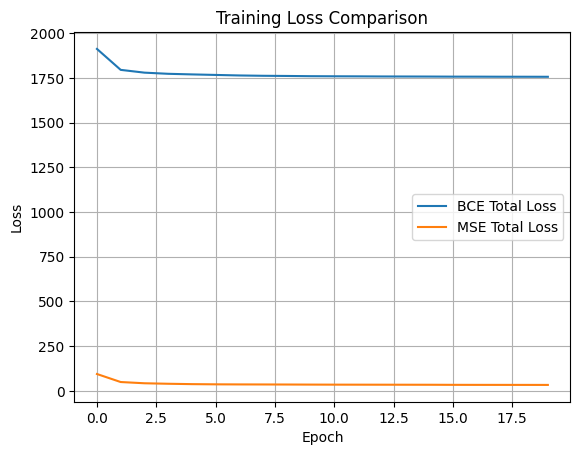

In [29]:
plt.plot(history_bce.history['loss'], label='BCE Total Loss')
plt.plot(history_mse.history['loss'], label='MSE Total Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Cell 8: Visualize Reconstructions

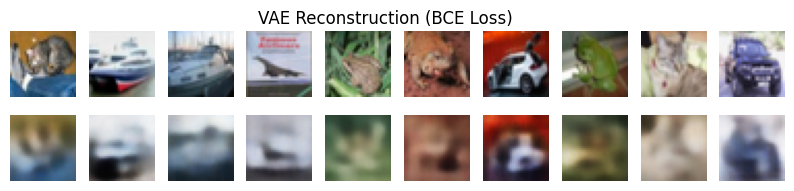

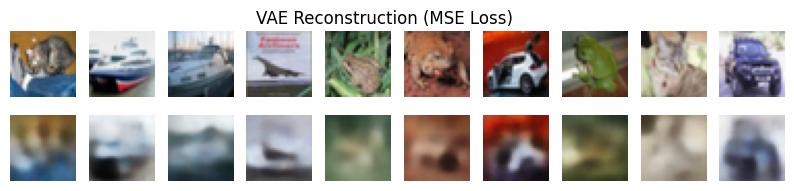

In [30]:
def show_reconstruction(vae, title):
    decoded = vae.decoder(vae.encoder(x_test[:10])[2])
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # Original
        plt.subplot(2, 10, i+1)
        plt.imshow(x_test[i])
        plt.axis('off')
        # Reconstructed
        plt.subplot(2, 10, i+11)
        plt.imshow(decoded[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_reconstruction(vae_bce, "VAE Reconstruction (BCE Loss)")
show_reconstruction(vae_mse, "VAE Reconstruction (MSE Loss)")

Cell 9: t-SNE Visualization of Latent Space

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


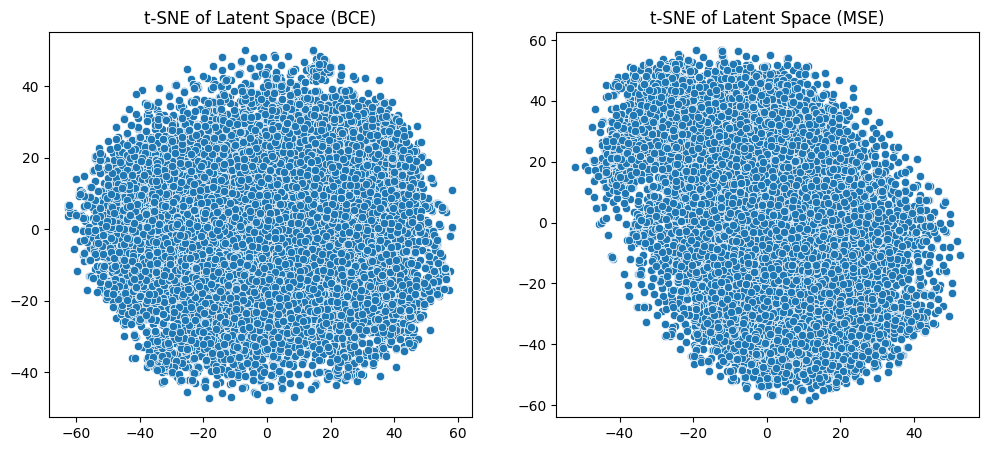

In [31]:
z_bce = encoder_bce.predict(x_test)[0]
z_mse = encoder_mse.predict(x_test)[0]

tsne_bce = TSNE(n_components=2).fit_transform(z_bce)
tsne_mse = TSNE(n_components=2).fit_transform(z_mse)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_bce[:, 0], y=tsne_bce[:, 1])
plt.title("t-SNE of Latent Space (BCE)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_mse[:, 0], y=tsne_mse[:, 1])
plt.title("t-SNE of Latent Space (MSE)")
plt.show()


# 1. Plot training and validation losses for BCE and MSE VAEs

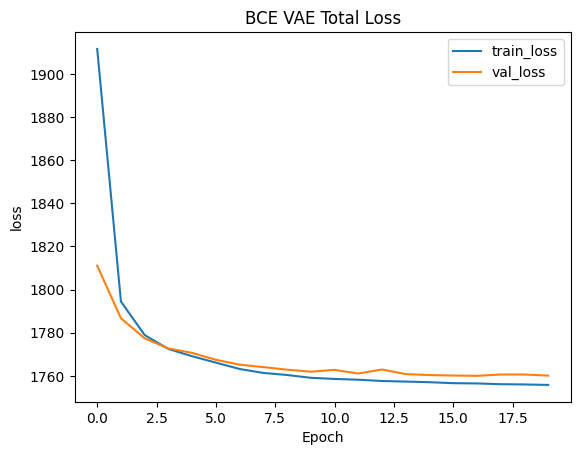

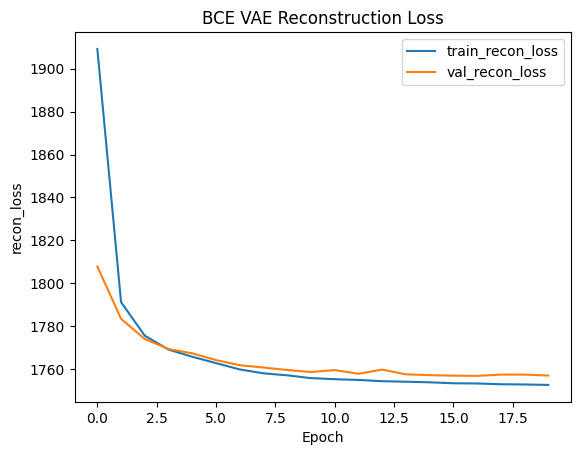

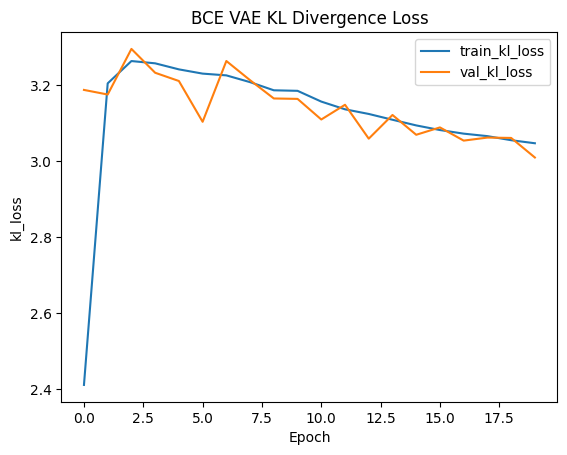

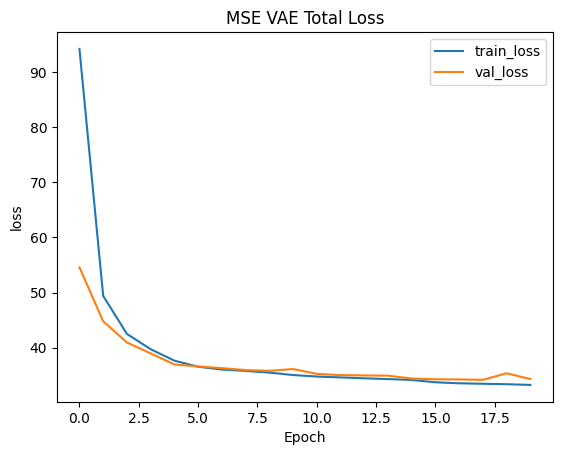

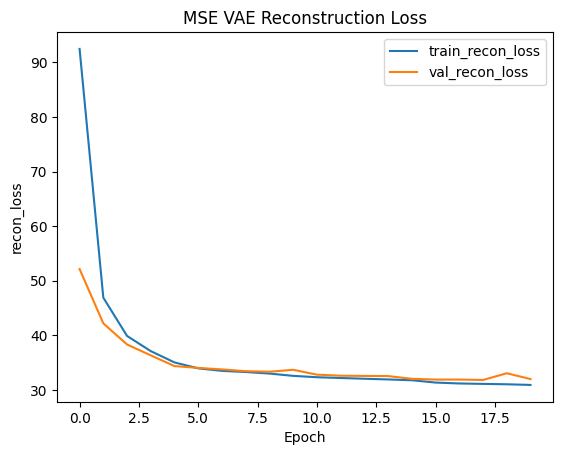

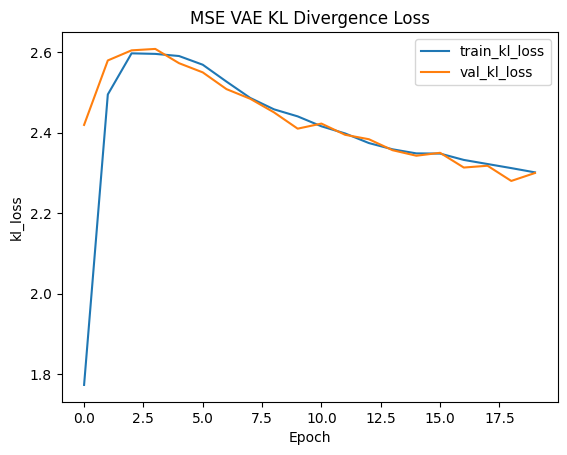

In [32]:
def plot_loss(history, loss_name, title):
    plt.plot(history.history[loss_name], label='train_'+loss_name)
    plt.plot(history.history['val_'+loss_name], label='val_'+loss_name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(loss_name)
    plt.legend()
    plt.show()

plot_loss(history_bce, 'loss', 'BCE VAE Total Loss')mac
plot_loss(history_bce, 'recon_loss', 'BCE VAE Reconstruction Loss')
plot_loss(history_bce, 'kl_loss', 'BCE VAE KL Divergence Loss')

plot_loss(history_mse, 'loss', 'MSE VAE Total Loss')
plot_loss(history_mse, 'recon_loss', 'MSE VAE Reconstruction Loss')
plot_loss(history_mse, 'kl_loss', 'MSE VAE KL Divergence Loss')


2. Visualize Reconstructions

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


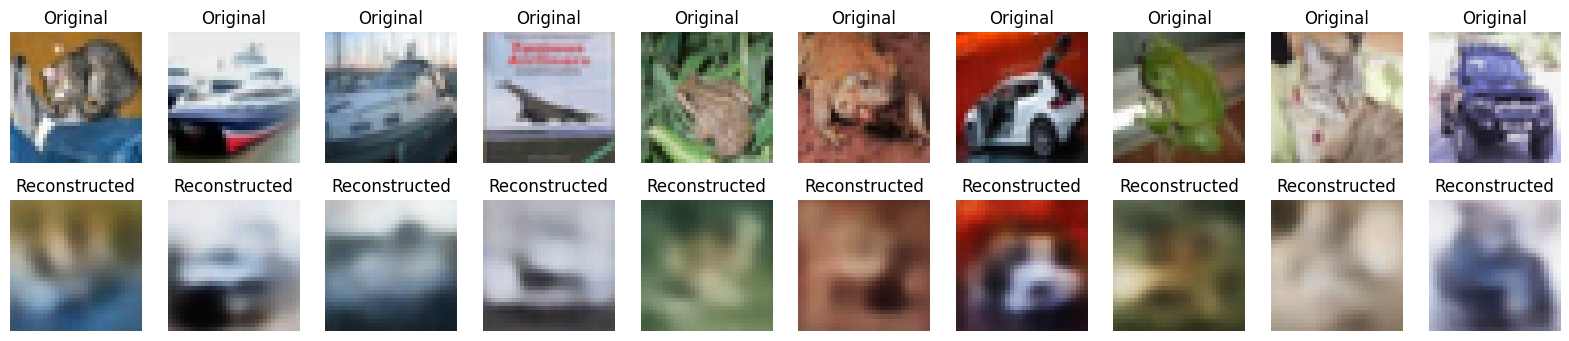

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


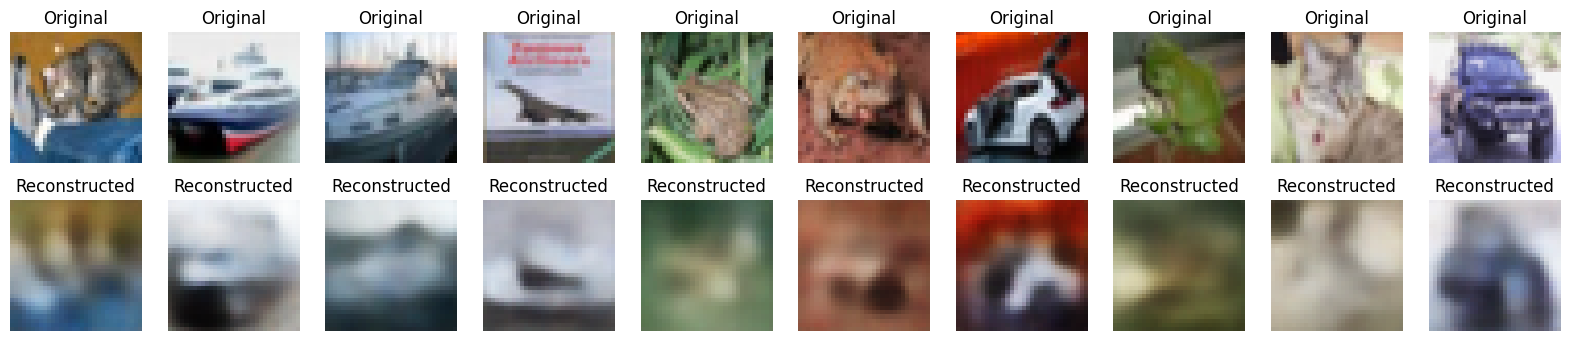

In [33]:
def display_reconstructions(model, data, n=10):
    decoded = model.decoder.predict(model.encoder(data)[2])
    plt.figure(figsize=(20,4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(data[i])
        plt.title("Original")
        plt.axis('off')

        # reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i])
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

display_reconstructions(vae_bce, x_test)
display_reconstructions(vae_mse, x_test)
